In [1]:
import os
import subprocess
import sys

ROOT_DIR = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).rstrip().decode('utf-8')
sys.path.append(os.path.join(ROOT_DIR, 'code'))

import config

#### Loading Libraries and Data

In [2]:
import numpy as np
import pandas as pd
import nltk

from sklearn import ensemble, feature_extraction, metrics, preprocessing

In [3]:
train      = pd.read_csv(os.path.join(config.DATA_DIR, 'sales_train.csv.gz'))
test       = pd.read_csv(os.path.join(config.DATA_DIR, 'test.csv.gz'))
submission = pd.read_csv(os.path.join(config.DATA_DIR, 'sample_submission.csv.gz'))
items      = pd.read_csv(os.path.join(config.DATA_DIR, 'items.csv'))
item_cats  = pd.read_csv(os.path.join(config.DATA_DIR, 'item_categories.csv'))
shops      = pd.read_csv(os.path.join(config.DATA_DIR, 'shops.csv'))
print('train:', train.shape, 'test:', test.shape)

train: (2935849, 6) test: (214200, 3)


In [4]:
set(train.columns) - set(test.columns)

{'date', 'date_block_num', 'item_cnt_day', 'item_price'}

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


#### Adding Features

* Text Features
* Date Features (Not Necessarily needed for monthly summary but may help if using daily preds)

In [7]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Length of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items.head()

,item_name,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,...,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.403761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483839
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [8]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len) #Length of Item Category Description
item_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
item_cats.head()

,item_category_name,item_category_id,item_category_name_len,item_category_name_wc,item_category_name_tfidf_0,item_category_name_tfidf_1,item_category_name_tfidf_2,item_category_name_tfidf_3,item_category_name_tfidf_4,item_category_name_tfidf_5,...,item_category_name_tfidf_15,item_category_name_tfidf_16,item_category_name_tfidf_17,item_category_name_tfidf_18,item_category_name_tfidf_19,item_category_name_tfidf_20,item_category_name_tfidf_21,item_category_name_tfidf_22,item_category_name_tfidf_23,item_category_name_tfidf_24
0,PC - Гарнитуры/Наушники,0,23,3,0.0,0.0,0.0,1.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Аксессуары - PS2,1,16,3,0.0,0.0,0.0,0.0,0.780837,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Аксессуары - PS3,2,16,3,0.0,0.0,0.0,0.0,0.000000,0.780837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Аксессуары - PS4,3,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Аксессуары - PSP,4,16,3,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Text Features
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len) #Length of Shop Name
shops['shop_name_len'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops.head()

,shop_name,shop_id,shop_name_len,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,"!Якутск ТЦ ""Центральный"" фран",1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.322815,0.0,0.689588,0.648274
2,"Адыгея ТЦ ""Мега""",2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.498580,0.0,0.000000,0.000000
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Волжский ТЦ ""Волга Молл""",4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.423972,0.0,0.000000,0.000000


In [10]:
#Make Monthly
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop(['date', 'item_price'], axis=1)
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day': 'item_cnt_month'})
#Monthly Mean
shop_item_monthly_mean = train[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month': 'item_cnt_month_mean'})
#Add Mean Feature
train = pd.merge(train, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
#Last Month (Oct 2015)
shop_item_prev_month = train[train['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month': 'item_cnt_prev_month'})
#Add Previous Month Feature
train = pd.merge(train, shop_item_prev_month, how='left', on=['shop_id', 'item_id']).fillna(0.)
#Items features
train = pd.merge(train, items, how='left', on='item_id')
#Item Category features
train = pd.merge(train, item_cats, how='left', on='item_category_id')
#Shops features
train = pd.merge(train, shops, how='left', on='shop_id')
train.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,...,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
test['month'] = 11
test['year'] = 2015
test['date_block_num'] = 34
#Add Mean Feature
test = pd.merge(test, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id']).fillna(0.)
#Add Previous Month Feature
test = pd.merge(test, shop_item_prev_month, how='left', on=['shop_id', 'item_id']).fillna(0.)
#Items features
test = pd.merge(test, items, how='left', on='item_id')
#Item Category features
test = pd.merge(test, item_cats, how='left', on='item_category_id')
#Shops features
test = pd.merge(test, shops, how='left', on='shop_id')
test['item_cnt_month'] = 0.
test.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,...,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24,item_cnt_month
0,0,5,5037,11,2015,34,1.444444,0.0,"NHL 15 [PS3, русские субтитры]",19,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Visualize

In [12]:
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

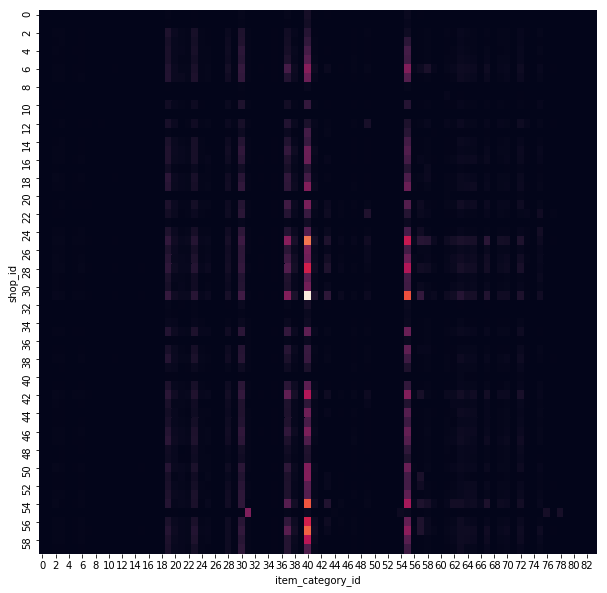

In [13]:
df_all = pd.concat((train, test), axis=0, ignore_index=True)
stores_hm = df_all.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(stores_hm, ax=ax, cbar=False)

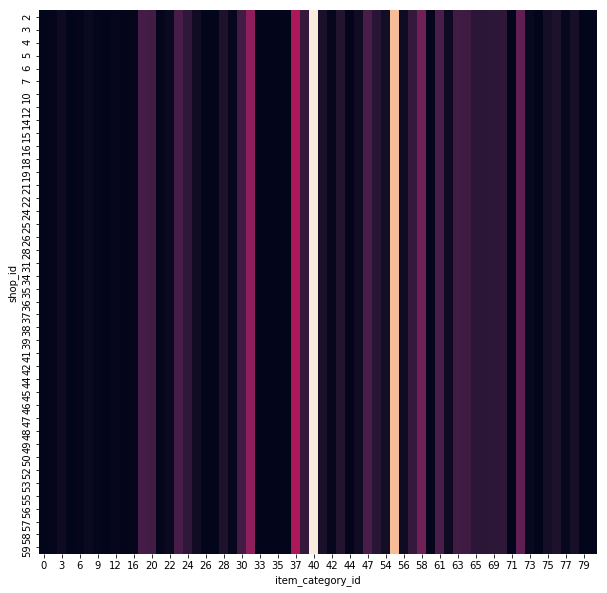

In [14]:
stores_hm = test.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.heatmap(stores_hm, ax=ax, cbar=False)

#### Label Encoding

* Try different approaches - weight based sequence, etc.

In [15]:
for c in ['shop_name', 'item_name', 'item_category_name']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[c].unique()) + list(test[c].unique()))
    train[c] = lbl.transform(train[c].astype(str))
    test[c] = lbl.transform(test[c].astype(str))
    print(c)

shop_name
item_name
item_category_name


#### Train & Predict Models

In [16]:
col = [c for c in train.columns if c not in ['item_cnt_month']]
#Validation Hold Out Month
x1 = train[train['date_block_num'] < 33]
y1 = np.log1p(x1['item_cnt_month'].clip(0., 20.))
x1 = x1[col]
x2 = train[train['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0., 20.))
x2 = x2[col]

reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=18)
reg.fit(x1, y1)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2.clip(0., 20.), reg.predict(x2).clip(0., 20.))))
#full train
reg.fit(train[col], train['item_cnt_month'].clip(0., 20.))
test['item_cnt_month'] = reg.predict(test[col]).clip(0., 20.)
test[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)

RMSE: 0.2787846905766576


#### Getting Started with More Models

* Off to model tuning land you go now...

In [17]:
#!pip install -U catboost
#!pip install -U lightgbm
#!pip install -U xgboost==0.6a2

In [18]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

/anaconda3/envs/kaggle/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
#XGBoost
def xgb_rmse(preds, y):
    y = y.get_label()
    score = np.sqrt(metrics.mean_squared_error(y.clip(0., 20.), preds.clip(0., 20.)))
    return 'RMSE', score

In [20]:
params = {'eta': 0.2, 'max_depth': 4, 'objective': 'reg:linear', 'eval_metric': 'rmse', 'seed': 18, 'silent': True}
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
xgb_model = xgb.train(params, xgb.DMatrix(x1, y1), 100, watchlist, verbose_eval=10, feval=xgb_rmse, maximize=False, early_stopping_rounds=20)
test['item_cnt_month'] = xgb_model.predict(xgb.DMatrix(test[col]), ntree_limit=xgb_model.best_ntree_limit)
test[['ID', 'item_cnt_month']].to_csv('xgb_submission.csv', index=False)

[0]	train-RMSE:0.555144	valid-RMSE:0.522299
Multiple eval metrics have been passed: 'valid-RMSE' will be used for early stopping.

Will train until valid-RMSE hasn't improved in 20 rounds.
[10]	train-RMSE:0.325569	valid-RMSE:0.272592
[20]	train-RMSE:0.318358	valid-RMSE:0.27291
[30]	train-RMSE:0.316888	valid-RMSE:0.272989
Stopping. Best iteration:
[12]	train-RMSE:0.322317	valid-RMSE:0.272369



In [21]:
#LightGBM
def lgb_rmse(preds, y):
    y = np.array(list(y.get_label()))
    score = np.sqrt(metrics.mean_squared_error(y.clip(0., 20.), preds.clip(0., 20.)))
    return 'RMSE', score, False

In [22]:
params = {'learning_rate': 0.2, 'max_depth': 7, 'boosting': 'gbdt', 'objective': 'regression', 'metric': 'mse', 'is_training_metric': False, 'seed': 18}
lgb_model = lgb.train(params, lgb.Dataset(x1, label=y1), 100, lgb.Dataset(x2, label=y2), feval=lgb_rmse, verbose_eval=10, early_stopping_rounds=20)
test['item_cnt_month'] = lgb_model.predict(test[col], num_iteration=lgb_model.best_iteration)
test[['ID', 'item_cnt_month']].to_csv('lgb_submission.csv', index=False)

Training until validation scores don't improve for 20 rounds.
[10]	valid_0's l2: 0.077239	valid_0's RMSE: 0.277919
[20]	valid_0's l2: 0.07445	valid_0's RMSE: 0.272855
[30]	valid_0's l2: 0.0747824	valid_0's RMSE: 0.273464
[40]	valid_0's l2: 0.0735981	valid_0's RMSE: 0.27129
[50]	valid_0's l2: 0.0723807	valid_0's RMSE: 0.269037
[60]	valid_0's l2: 0.0724814	valid_0's RMSE: 0.269224
Early stopping, best iteration is:
[41]	valid_0's l2: 0.0721355	valid_0's RMSE: 0.268581


In [23]:
#CatBoost
cb_model = CatBoostRegressor(iterations=100, learning_rate=0.2, depth=7, loss_function='RMSE', eval_metric='RMSE', random_seed=18, od_type='Iter', od_wait=20)
cb_model.fit(x1, y1, eval_set=(x2, y2), use_best_model=True, verbose=False)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2.clip(0., 20.), cb_model.predict(x2).clip(0., 20.))))
test['item_cnt_month'] += cb_model.predict(test[col])
test['item_cnt_month'] /= 2
test[['ID', 'item_cnt_month']].to_csv('cb_blend_submission.csv', index=False)

RMSE: 0.2755814068250796


In [24]:
test['item_cnt_month'] = np.expm1(test['item_cnt_month'])
test[['ID', 'item_cnt_month']].to_csv('cb_submission_exp.csv', index=False)